# Sentiment Training

In this notebook, we trained our own sentiment analysis models in order to replace vaderSentiment.

A manual verification of the sentiments assigned by vaderSentiment had shown to be not very accurate. We hypothesised that this was in part due to the fact that the vocabulary found on r/wallstreetbets is very different from the vocabulary found within vaderSentiment's training data (e.g. words such as "autists" would have a negative connotation elsewhere, but in r/wallstreetbets, it is used as a neutral term to refer to its users).

Due to the lack of time and resources, we used the sample of posts previously generated by `1-GetSenData.ipynb` and manually relabelled them to the best of our ability. In order to prevent potential biases, we went through the relabelling process as a team and discussed how each post should be labelled.

We used a bag-of-words model (sklearn's `CountVectorizer`) to first generate a numerical representation of a post's text data. We then tested out a few classical machine learning algorithms. Ultimately, we found that the logistic regression model performed the best, and decided to use that as the sentiment-label generator for the other posts.

In [14]:
import numpy as np
import pandas as pd
import pickle
from google.colab import drive
from collections import deque
import itertools

# Mount GDrive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
df = pd.read_csv("gdrive/MyDrive/AI Project/Reddit/sentiment_df.csv")

df_all = pd.read_csv("gdrive/MyDrive/AI Project/Reddit/01-updated.csv")
df_all = df_all.append(pd.read_csv("gdrive/MyDrive/AI Project/Reddit/02-updated.csv"), ignore_index=True)
df_all = df_all.append(pd.read_csv("gdrive/MyDrive/AI Project/Reddit/03-updated.csv"), ignore_index=True)
df_all = df_all.append(pd.read_csv("gdrive/MyDrive/AI Project/Reddit/04-updated.csv"), ignore_index=True)
df_all = df_all.append(pd.read_csv("gdrive/MyDrive/AI Project/Reddit/05-updated.csv"), ignore_index=True)
df_all = df_all.append(pd.read_csv("gdrive/MyDrive/AI Project/Reddit/06-updated.csv"), ignore_index=True)

In [3]:
# Random split train and test data using all the posts
index = df.index
df['random_number'] = np.random.randn(len(index))
train = df[df['random_number'] <= 0.7]
test = df[df['random_number'] > 0.7]

In [4]:
# Count vectorizer: CBoW here using ALL posts
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
vectorizer = vectorizer.fit(df_all['p'])
train_matrix = vectorizer.transform(train['text'])
test_matrix = vectorizer.transform(test['text'])

X_train = train_matrix
X_test = test_matrix
y_train = train['sentiment']
y_test = test['sentiment']

In [11]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

sentimental_model = LogisticRegression(max_iter=10000)

sentimental_model.fit(X_train,y_train)
predictions = sentimental_model.predict(X_test)

print(classification_report(predictions,y_test))
print(confusion_matrix(predictions, y_test))


              precision    recall  f1-score   support

          -2       0.43      0.56      0.49        18
          -1       0.17      0.17      0.17        23
           0       0.50      0.38      0.43        29
           1       0.45      0.32      0.38        28
           2       0.54      0.88      0.67        16

    accuracy                           0.42       114
   macro avg       0.42      0.46      0.43       114
weighted avg       0.42      0.42      0.41       114

[[10  4  2  0  2]
 [ 5  4  7  4  3]
 [ 2  8 11  7  1]
 [ 4  7  2  9  6]
 [ 2  0  0  0 14]]


In [18]:
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

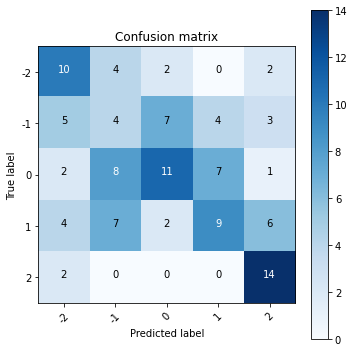

In [19]:
plt.figure(figsize=(5,5))
plot_confusion_matrix(confusion_matrix(predictions, y_test), [-2,-1,0,1,2])

In [ ]:
# SGDClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report

sentimental_model = SGDClassifier(max_iter=1000, tol=1e-3, loss="log")

sentimental_model.fit(X_train,y_train)
predictions = sentimental_model.predict(X_test)

print(classification_report(predictions,y_test))

              precision    recall  f1-score   support

          -2       0.41      0.45      0.43        20
          -1       0.47      0.33      0.39        27
           0       0.48      0.67      0.56        21
           1       0.45      0.39      0.42        23
           2       0.62      0.65      0.63        20

    accuracy                           0.49       111
   macro avg       0.49      0.50      0.49       111
weighted avg       0.49      0.49      0.48       111



In [ ]:
# XGBClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

sentimental_model = XGBClassifier()

sentimental_model.fit(X_train,y_train)
predictions = sentimental_model.predict(X_test)

print(classification_report(predictions,y_test))

              precision    recall  f1-score   support

          -2       0.18      0.29      0.22        14
          -1       0.26      0.21      0.23        24
           0       0.59      0.45      0.51        38
           1       0.25      0.28      0.26        18
           2       0.38      0.47      0.42        17

    accuracy                           0.35       111
   macro avg       0.33      0.34      0.33       111
weighted avg       0.38      0.35      0.36       111



In [ ]:
# Specify a path
PATH = "gdrive/MyDrive/AI Project/Reddit/sentiment.pkl"

# Save
with open(PATH, 'wb') as fout:
    pickle.dump((vectorizer, sentimental_model), fout)